In [1]:
## lenet 5 optimized and augmented v1 continued training with more epochs

In [6]:
import torch
print(torch.__version__)

2.2.2


In [9]:
# importing
import torch.nn as nn
import torch.nn.functional as F  # For activation functions and pooling
import torch.optim as optim  # # For optimizers (SGD, Adam, etc.)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset, ConcatDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Optional: set seed for reproducibility (helps make train/val split match original)
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


In [15]:
# load the data
# data is in this folder
train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

In [17]:
pwd

'/Users/lilywenger/MLM25/GitProjects/DigitRecognizer_Inkvestigators_mlm25/digit-recognizer'

In [20]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# separating out the labels from the pixel data features
X_train = train_df.drop('label', axis=1).values   # shape: (42000, 784)
y_train = train_df['label'].values                # shape: (42000,)
X_test = test_df.values                           # shape: (28000, 784)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (42000, 784)
y_train shape: (42000,)
X_test shape: (28000, 784)


In [26]:
# need to convert to PyTorch tensors and reshape
# converts to float32 and normalizes to [0,1]
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 28, 28) / 255.0
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 28, 28) / 255.0

print("X_train_tensor shape:", X_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)

X_train_tensor shape: torch.Size([42000, 1, 28, 28])
X_test_tensor shape: torch.Size([28000, 1, 28, 28])


In [29]:
# check the mean and standard deviation from the normalization
mean = X_train_tensor.mean().item()
std = X_train_tensor.std().item()
print(f"Training data mean: {mean:.4f}, std: {std:.4f}")

Training data mean: 0.1310, std: 0.3085


In [32]:
# Standardize the dataset: (x - mean) / std
# This centers the distribution around 0 with unit variance.
# --------------------------------------------------
X_train_tensor = (X_train_tensor - mean) / std
X_test_tensor  = (X_test_tensor - mean) / std

# Recompute mean and std to confirm the normalization worked
mean_after = X_train_tensor.mean().item()
std_after = X_train_tensor.std().item()

print(f"After standardization: mean={mean_after:.4f}, std={std_after:.4f}")

After standardization: mean=0.0000, std=1.0000


In [37]:
# We want to split into train and validation sets AND later create both
# original and augmented copies of the training data.
#
# Here we:
# 1. Randomly permute all indices
# 2. Take 80% for training and 20% for validation
# 3. Create:
#    - tensor subsets for training/validation (for the model)
#    - NumPy/pandas-based validation data for plotting/misclassification analysis.

num_samples = X_train_tensor.shape[0]

# Random permutation of indices [0, 1, ..., num_samples-1]
seed_value=24
torch.manual_seed(seed_value)
indices = torch.randperm(num_samples)

# 80/20 split
train_size = int(0.8 * num_samples)
train_indices = indices[:train_size]
val_indices   = indices[train_size:]

# Tensor subsets for model training/validation
X_train_train = X_train_tensor[train_indices]
y_train_train = y_train_tensor[train_indices]

X_val_tensor  = X_train_tensor[val_indices]
y_val_tensor  = y_train_tensor[val_indices]

print("Training tensor subset shape:", X_train_train.shape)
print("Validation tensor subset shape:", X_val_tensor.shape)

# Also create NumPy-based validation data for visualization (optional)
val_indices_np = val_indices.numpy()
X_val = pd.DataFrame(X_train[val_indices_np])
y_val = pd.Series(y_train[val_indices_np])

Training tensor subset shape: torch.Size([33600, 1, 28, 28])
Validation tensor subset shape: torch.Size([8400, 1, 28, 28])


In [100]:
# Data Augmentation
# augmentations are:
# 1. Random rotation between 0 and 15 degrees
# 2. Random translation up to 10% of the image height/width
# 3. Random contrast decrease between 0% and 30%
# 4. Image inversion
#
# We implement these using torchvision.transforms on TENSOR images
# (shape [1, 28, 28] with values in [0, 1]).

augment_transform = transforms.Compose([
    # RandomAffine can do rotation + translation in one transform.
    transforms.RandomAffine(
        degrees=(0, 15),      # Rotation sampled from [0°, 15°]
        translate=(0.1, 0.1)  # Up to 10% shift in both x and y
    ),
    # ColorJitter on a grayscale tensor will adjust "contrast" by scaling around the mean.
    # contrast=(0.7, 1.0) means:
    #   - 1.0 => no change
    #   - 0.7 => 30% lower contrast
    transforms.ColorJitter(contrast=(0.7, 1.0)),
    # Randomly invert the image (white <-> black) with probability 0.5
    transforms.RandomInvert(p=0.5),
])

# Basic transform for non-augmented data.
# Since our tensors are already [0,1], we don't need to do much here.
# But we keep this for symmetry and to make it easy to tweak later.
def identity_transform(x):
    return x

class TensorDatasetWithTransform(Dataset):
    """
    A custom Dataset that wraps a pair of tensors (data, labels) and optionally
    applies a transform to each sample on-the-fly when __getitem__ is called.
    """
    def __init__(self, data_tensor, target_tensor, transform=None):
        """
        Parameters
        ----------
        data_tensor : torch.Tensor
            Tensor of images, shape [N, 1, 28, 28], already normalized to [0, 1].
        target_tensor : torch.Tensor
            Tensor of integer labels, shape [N].
        transform : callable or None
            A function/transform applied to each image tensor.
        """
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor
        self.transform = transform

    def __len__(self):
        # Number of samples in the dataset
        return self.data_tensor.shape[0]

    def __getitem__(self, idx):
        # Get the image and label at position idx
        x = self.data_tensor[idx]
        y = self.target_tensor[idx]

        # Apply the transform (if provided) to the image only
        if self.transform is not None:
            x = self.transform(x)

        return x, y

In [102]:
# making two different training sets: original and augmented
# 1. identity transform - original dataset
# 2. augmented transform
# then we concatenate so that they are all together
# the augmented is randomly transformed each epoch

# Original (clean) training samples
train_original_dataset = TensorDatasetWithTransform(
    data_tensor=X_train_train,
    target_tensor=y_train_train,
    transform=identity_transform   # or None; both are fine
)

# Augmented training samples
train_augmented_dataset = TensorDatasetWithTransform(
    data_tensor=X_train_train,
    target_tensor=y_train_train,
    transform=augment_transform
)

# Combine original + augmented for training
train_dataset = ConcatDataset([train_original_dataset, train_augmented_dataset])

# Validation dataset (no augmentation)
val_dataset = TensorDatasetWithTransform(
    data_tensor=X_val_tensor,
    target_tensor=y_val_tensor,
    transform=identity_transform
)



# writing up the data loaders 
# allows for batches of specified size to make training more efficient
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(X_test_tensor, batch_size=128, shuffle=False)


In [104]:
print("Train dataset length (original + augmented):", len(train_dataset))
print("Validation dataset length:", len(val_dataset))

Train dataset length (original + augmented): 67200
Validation dataset length: 8400


In [119]:
# set up the optimized LeNet model
# differences from the baseline model include using: 
# ReLU instead of tanh, MaxPool instead of AvgPool, BatchNorm for stability, and Dropout for normalization
class LeNet5_Optimized(nn.Module):
    def __init__(self):
        super(LeNet5_Optimized, self).__init__()
        # Convolutional layer 1: 1 input channel, 6 output feature maps
        # kernel_size=5, padding=2 keeps spatial size at 28x28
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm2d(6)            # BatchNorm stabilizes learning
        
        # Convolutional layer 2: 6 input, 16 output channels
        # kernel_size=5, no padding -> output size 10x10
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2   = nn.BatchNorm2d(16)
        
        # Fully connected layers
        # After conv and pooling:
        #   Input: 28x28
        #   Conv1 -> 28x28
        #   Pool -> 14x14
        #   Conv2 -> 10x10
        #   Pool -> 5x5
        # so flatten size = 16 * 5 * 5 = 400.
        self.fc1 = nn.Linear(16 * 5 * 5, 120)     # Flattened conv output → 120
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)              # 10 digits → 10 output logits
        
        # Dropout regularization (prevents overfitting)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # ---- Conv Block 1 ----
        # Conv → BatchNorm → ReLU → MaxPool
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 28x28 -> 14x14
        
        # ---- Conv Block 2 ----
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 10x10 -> 5x5
        
        # ---- Flatten ----
        x = x.view(-1, 16 * 5 * 5)
        
        # ---- Fully Connected Layers ----
        x = F.relu(self.fc1(x))
        x = self.dropout(x)             # randomlt Drop some units neurons to avoid overfitting
        x = F.relu(self.fc2(x))
        x = self.fc3(x)                 # Output raw logits
        return x

In [121]:
# the training set up
model = LeNet5_Optimized().to(device)

# CrossEntropyLoss combines softmax + negative log likelihood.
criterion = nn.CrossEntropyLoss()

# Adam optimizer adapts learning rates for each parameter.
# weight_decay adds L2 regularization for further generalization.
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler gradually decreases the LR every 5 epochs by 20%.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)


In [123]:
## THIS IS WHERE I AM LOADING IN THE DICTIONARIES OF THE WEIGHTS FROM THE FIRST 50 EPOCHS OF TRAINING

checkpoint_path = "aug_lenet5_model_v1.pth"

checkpoint = torch.load(checkpoint_path, map_location=device)

# Load model weights, optimizer, scheduler state
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

# Metadata
start_epoch = checkpoint["epoch"] + 1
best_val_acc = checkpoint["best_val_acc"]

print(f"Loaded checkpoint from {checkpoint_path}")
print(f"Resuming training from epoch {start_epoch}, best_val_acc={best_val_acc:.2f}%")

Loaded checkpoint from aug_lenet5_model_v1.pth
Resuming training from epoch 50, best_val_acc=99.33%


In [125]:
# training the model
extra_epochs=50
patience=20
best_val_acc=0.0
epochs_no_improve=0
best_model_state = None


for epoch in range(start_epoch, start_epoch + extra_epochs):
    model.train()                        # Enable dropout + batchnorm updates
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    
    # ---- Training phase ----
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()            # Reset gradient buffers
        output = model(data)             # Forward pass
        loss = criterion(output, target) # Compute cross-entropy loss
        loss.backward()                  # Backpropagate gradients
        optimizer.step()                 # Update weights
        
        running_loss += loss.item()  * data.size(0)    # Accumulate batch loss

        # Compute training accuracy for monitoring
        _, preds = torch.max(output, dim=1)
        correct_train += (preds == target).sum().item()
        total_train += data.size(0)

# Average training loss and accuracy over the epoch
    train_loss = running_loss / total_train
    train_acc = correct_train / total_train * 100.0
    
    scheduler.step()                     # Adjust learning rate schedule if using scheduler
    
      # ---- Validation phase ----
    model.eval()                  # Evaluation mode: disable dropout, etc.
    val_loss_total = 0.0
    correct_val = 0
    total_val = 0


    # We also store predictions if you want to analyze misclassifications later
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            
            # Compute validation loss
            loss = criterion(outputs, target)
            val_loss_total += loss.item()*data.size(0)

            # Compute validation accuracy
            _, preds = torch.max(outputs, dim=1)
            total_val += data.size(0)
            correct_val += (preds == target).sum().item()
            
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(target.cpu().numpy())

    val_loss = val_loss_total / total_val
    val_acc = correct_val / total_val * 100.0

    # ---- Early stopping logic ----
    if val_acc > best_val_acc:
        # If validation accuracy improved, save model state
        best_val_acc = checkpoint["best_val_acc"]
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        # Otherwise, increase the counter
        epochs_no_improve += 1

    # Print metrics for this epoch
    total_epochs = start_epoch + extra_epochs
    
    print(
        f"Epoch [{epoch+1}/{total_epochs}] "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%  "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
    )

    # Trigger early stopping if no improvement for 'patience' epochs
    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restore the best model weights (highest validation accuracy)
if best_model_state is not None:
    model.load_state_dict(best_model_state)

print(f"Training completed. Best validation accuracy: {best_val_acc:.2f}%")

Epoch [51/100] Train Loss: 0.0517, Train Acc: 98.36%  Val Loss: 0.0439, Val Acc: 99.29%
Epoch [52/100] Train Loss: 0.0520, Train Acc: 98.36%  Val Loss: 0.0439, Val Acc: 99.35%
Epoch [53/100] Train Loss: 0.0515, Train Acc: 98.40%  Val Loss: 0.0433, Val Acc: 99.29%
Epoch [54/100] Train Loss: 0.0501, Train Acc: 98.42%  Val Loss: 0.0441, Val Acc: 99.25%
Epoch [55/100] Train Loss: 0.0505, Train Acc: 98.37%  Val Loss: 0.0442, Val Acc: 99.30%
Epoch [56/100] Train Loss: 0.0486, Train Acc: 98.47%  Val Loss: 0.0452, Val Acc: 99.33%
Epoch [57/100] Train Loss: 0.0491, Train Acc: 98.51%  Val Loss: 0.0460, Val Acc: 99.33%
Epoch [58/100] Train Loss: 0.0478, Train Acc: 98.51%  Val Loss: 0.0446, Val Acc: 99.30%
Epoch [59/100] Train Loss: 0.0493, Train Acc: 98.47%  Val Loss: 0.0461, Val Acc: 99.33%
Epoch [60/100] Train Loss: 0.0488, Train Acc: 98.46%  Val Loss: 0.0460, Val Acc: 99.31%
Epoch [61/100] Train Loss: 0.0477, Train Acc: 98.47%  Val Loss: 0.0458, Val Acc: 99.36%
Epoch [62/100] Train Loss: 0.045

In [129]:
# generate csv for submission
model.eval()
predictions = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)  # Convert logits → predicted labels
        predictions.extend(predicted.cpu().numpy())

# Create submission DataFrame (format required by Kaggle)
submission = pd.DataFrame({
    "ImageId": np.arange(1, len(predictions) + 1),
    "Label": predictions
})

# Save predictions to CSV
submission.to_csv("Augmented_moreTrain_LeNet5_Optimized_submission_LW.csv", index=False)
print("Submission file 'Augmented_moreTrain_LeNet5_Optimized_submission_LW.csv' created successfully.")

Submission file 'Augmented_moreTrain_LeNet5_Optimized_submission_LW.csv' created successfully.


In [132]:
# save the model for later training since these 50 maxed out

checkpoint_path = "aug_moretrain_lenet5_model_v1.pth"  # name of the model file you want

torch.save({
    "epoch": epoch,                          # last epoch index from the loop
    "model_state_dict": model.state_dict(),  # model weights
    "optimizer_state_dict": optimizer.state_dict(),  # optimizer state
    "scheduler_state_dict": scheduler.state_dict(),  # scheduler state
    "best_val_acc": best_val_acc,            # best validation accuracy
}, checkpoint_path)

print(f"Checkpoint saved to {checkpoint_path}")


## also note that this model in some places is called the LeNet5 optimized but it has the augmentation too

Checkpoint saved to aug_moretrain_lenet5_model_v1.pth


Misclassified 61 out of 8400 validation samples.


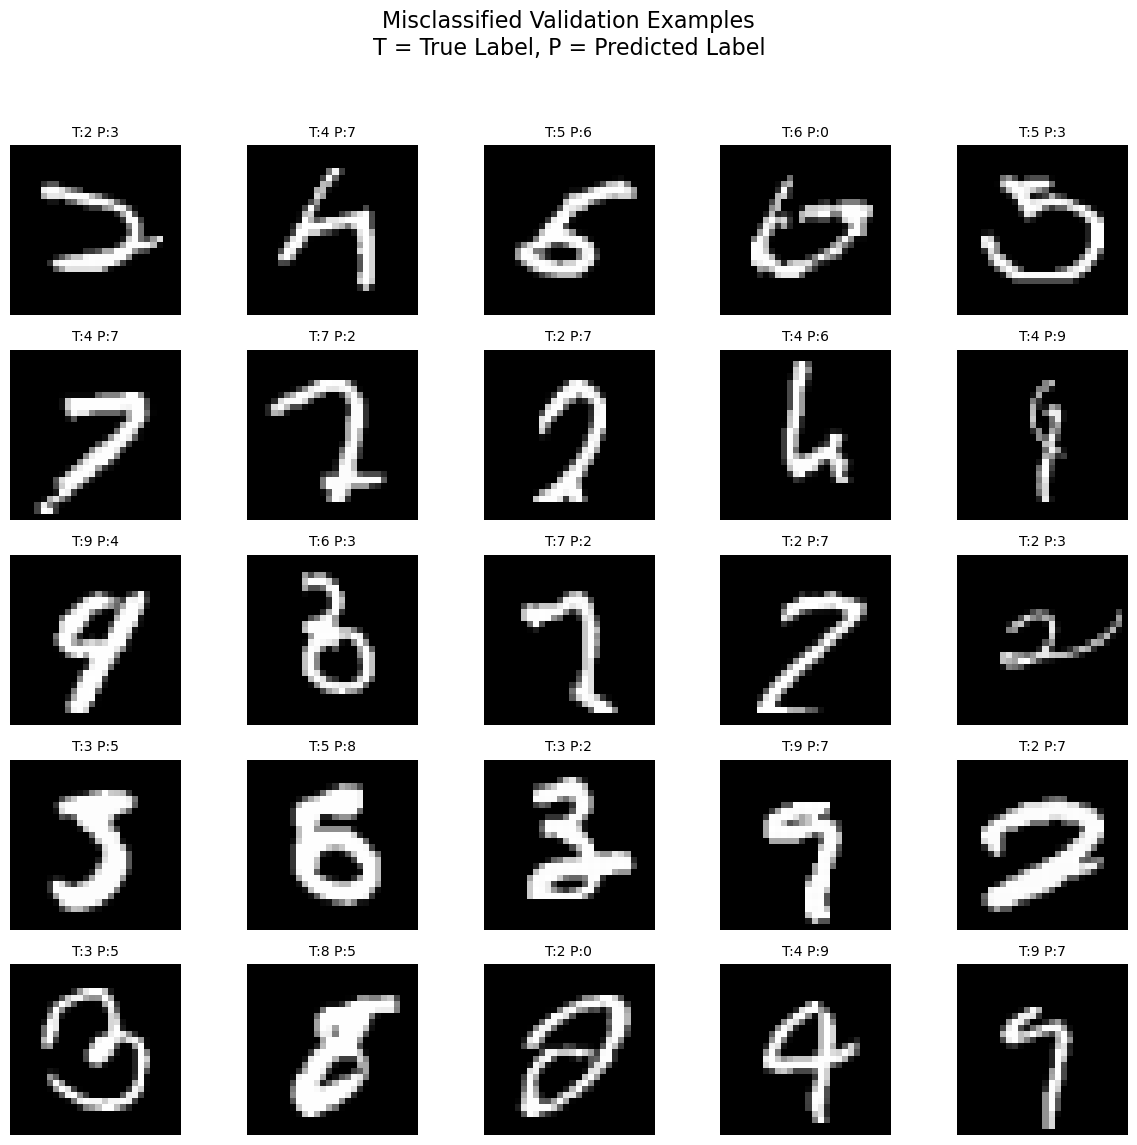

In [137]:
# Cell 14: Visualize misclassified validation images

import numpy as np
import matplotlib.pyplot as plt

# Ensure model is in evaluation mode
model.eval()

# We will reuse the same validation tensors (X_val_tensor, y_val_tensor)
# and wrap them into a Dataset + DataLoader for convenience.
val_vis_dataset = TensorDatasetWithTransform(
    data_tensor=X_val_tensor,
    target_tensor=y_val_tensor,
    transform=identity_transform  # no augmentation for visualization
)

val_vis_loader = DataLoader(
    val_vis_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=0
)

all_val_preds = []
all_val_labels = []
# 1. Run model on the entire validation set and collect predictions/labels
with torch.no_grad():
    for data, target in val_vis_loader:
        data = data.to(device)
        target = target.to(device)

        outputs = model(data)
        _, predicted = torch.max(outputs, dim=1)

        all_val_preds.extend(predicted.cpu().numpy())
        all_val_labels.extend(target.cpu().numpy())

all_val_preds = np.array(all_val_preds)
all_val_labels = np.array(all_val_labels)

# 2. Find indices where prediction != true label
mis_idx = np.where(all_val_preds != all_val_labels)[0]
num_misclassified = len(mis_idx)
total_val_samples = len(all_val_labels)

print(f"Misclassified {num_misclassified} out of {total_val_samples} validation samples.")
# 3. Visualize a subset of misclassified images
# We will use the ORIGINAL (pre-standardization) pixel values from X_val
# that we saved earlier as a DataFrame, so the images look like normal MNIST digits.

num_to_show = min(25, num_misclassified)  # show up to 25 misclassified examples
if num_to_show == 0:
    print("No misclassified examples to show!")
else:
    plt.figure(figsize=(12, 12))
    for i in range(num_to_show):
        idx = mis_idx[i]

        # X_val was constructed from the same validation indices, in the same order,
        # so row 'idx' in X_val corresponds to sample 'idx' in the validation set.
        img_flat = X_val.iloc[idx].values  # shape (784,)
        img = img_flat.reshape(28, 28)     # reshape to 28x28 for plotting

        true_label = all_val_labels[idx]
        pred_label = all_val_preds[idx]

        ax = plt.subplot(5, 5, i + 1)
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        ax.set_title(f"T:{true_label} P:{pred_label}", fontsize=10)

    plt.suptitle("Misclassified Validation Examples\nT = True Label, P = Predicted Label", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()